# Clasificación de audio con el Perceptrón Multicapa

# Parte I: Introducción al procesamiento de audio

En primera instancia debemos comprender como se representa digitalmente el audio y qué características fundamentales tiene

In [2]:
# Definimos un conjunto de constates con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

Para procesar el audio vamos a requerir una librería externa que debemos instalar en el contexto de nuestro Jupyter Notebook, concretamente la librería que vamos a utilizar es librosa: https://librosa.org/doc/latest/index.html

In [3]:
# Escuchamos el fichero de audio que vamos a cargar en el contexto de Jupyter Notebook
import IPython.display as ipd

ipd.Audio(os.path.join(BENJAMIN_DATA, '22.wav'))

In [4]:
# Cargamos el audio mediante la libreria librosa

import librosa

wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, '22.wav'))

El método load de librosa nos devuelve dos resultados:
    1. Nos devuelve la onda que representa el sonido que estamos cargando en el contexto de Jupyter Notebook
    2. Nos devuelve el ratio de sampleo
 
 El sonido es una señal analóga, para poder hacerla digital y poderla representar númericamente tenemos que muestrear la señal original
 
 El muestreo consiste en "seleccionar" un número finito de puntos de la señal original y almacenarlos en una matriz. El teorema de muestreo de Nyquist-shannon mostró que si nuestra tasa de muestreo suficientemente alta, somos capaces de capturar toda la información de la señal e incluso recuperarla completamente

In [5]:
print(wav)

[ 0.03905473  0.07648452  0.1407956  ... -0.01163534  0.01072754
  0.01446463]


In [6]:
print(sr)

22050


La tasa de muestreo es muy importante, y la usaremos más adelante en diferentes algoritmos. Generalmente se expresa en hercios (Hz), es decir, el número de puntos(muestras) por segundo.

En nuestro ejemplo sr= 22050, por lo que tenemos 22050 muestras por segundo, por lo tanto podemos calcular la logitud del audio de la siguiente forma:

In [8]:
# Con la tasa de muestre y el tamaño de la señal se puede calcular la longitud del audio
long_audio = len(wav)/sr
print('La longitud del audio en segundos es: ', long_audio)

La longitud del audio en segundos es:  1.0


Una de las cosas interesantes que podemos hacer para obtener intuiciones sobre nuestra onda de sonido es representarla gráficamente

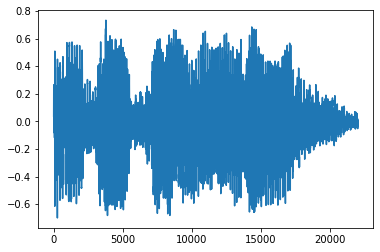

In [9]:
# Representación gráfica de la onda de sonido
from matplotlib import pyplot as plt

plt.plot(wav)
plt.show()

También podemos hacer zoom en determinados puntos especificos seleccionados durante el muestreo

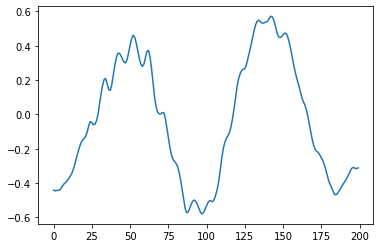

In [10]:
plt.plot(wav[1000:1200])
plt.show()

    Hay algo que tenemos que tener en cuenta respecto a lo comentado anteriormente, en realidad, la tasa de muestreo real para el audio que hemos cargano no es de 22050 Hz, librosa implicitamente remuestrea nuestros archivos para obtener este valor estándar. Para obtener la tasa de muestreo original, podemos usar el argumento sr=False en el método load

In [11]:
wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, '22.wav'), sr=None )

In [12]:
print('Tasa de muestreo: {} Hz'.format(sr))

Tasa de muestreo: 16000 Hz


# 1. Preparación del conjunto de datos

Vamos a comenzar tratando de utilizar esta representación del sonido para identificar el orador al que pertenece la grabación mediante el uso de un Perceptrón Multicapa.

Hay que tener en cuenta que para este tipo de casos prácticos debemos intentar buscar las voces de los oradores emitidas por diferentes altavoces o dispositivos de sonido para que la clasificación no dependa del altavoz que se está utilizando

In [18]:
# Definir una función para parsear nuestro conjunto de datos
def parse_datase(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print('[+] Parsing {} data...'.format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            X.append(wav)
            y.append(index)
    return (X, y)

In [19]:
X, y = parse_datase([BENJAMIN_DATA, JENS_DATA])

[+] Parsing 16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing 16000_pcm_speeches\Jens_Stoltenberg data...


In [20]:
print('La longitud del conjunto de datos es: ', len(X))

La longitud del conjunto de datos es:  3000


# 2. División del conjunto de datos

In [21]:
# Dividimos el conjunto de datos en entreamiento y pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [22]:
print('Longitud del subconjunto de entrenamiento: ', len(X_train))
print('Longitud del subconjunto de pruebas: ', len(X_test))

Longitud del subconjunto de entrenamiento:  2850
Longitud del subconjunto de pruebas:  150


# 3. Construcción del modelo

In [23]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train, y_train)

C:\Users\luigi\.conda\envs\curso_deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [24]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test)

In [25]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='binary')

0.5853658536585366

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[34, 38],
       [30, 48]], dtype=int64)

# Parte II: Otra parte de predicción de sonido

Como podemos observar en el ejercicio anterior si utilizamos las ondas tal cual estamos leyendo en el disco, los resultados de nuestro algoritmo no son demasiado buenos por ello, vamos a utilizar otra represntación del sonido, conocida como espectrogramas.

Antes de comprender lo que es un espectrograma, debemos comprender lo que son las ondas coseno o cosinusoide

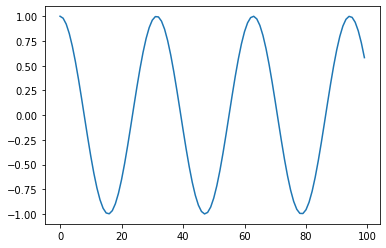

In [27]:
import numpy as np

signal = np.cos(np.arange(0, 20, 0.2))

plt.plot(signal)
plt.show()

Puede observarse que corresponden con un tipo de ondas sencillas, cuya curva describe una oscilación repetitiva y suave. De manera muy sencilla podemos modificar este patrón cambiando la aplitud y frecuencia de la onda

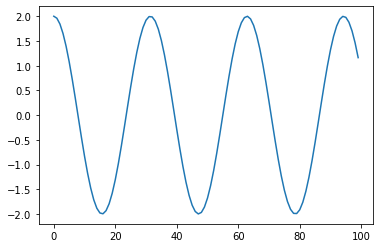

In [28]:
signal = 2 * np.cos(np.arange(0, 20, 0.2))

plt.plot(signal)
plt.show()

También podemos combinar 2 ondas de este tipo formando ondas más complejas:

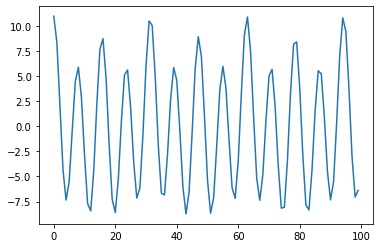

In [30]:
cos1 = np.cos(np.arange(0, 20, 0.2))
cos2 = 2 * np.cos(np.arange(0, 20, 0.2)*2)
cos3 = 8 * np.cos(np.arange(0, 20, 0.2)*4)

signal = cos1 + cos2 + cos3

plt.plot(signal)
plt.show()

Para poder proporcionar estas ondas a nuestra Red Neuronal Artificial necesitamos un represenación de la misma. Podemos utilizar varias representaciones.

    1.Almacenar la señal completa, que es considerablemente compleja y que hemos comprobado que no proporciona buenos resultados
    2. Podemos almacenar únicamente las frecuencias que se utilizan en la señal.

Representar únicamente las frecuencias de la señal es más simple y requiere mucho menos espacio en memoria, Aquí tenemos 3 frecuencia diferentes con diferentes amplitudes. La pregunta que debemos hacer es: ¿Cuáles son exactamente esas 3 frecuencias?

Necesitamos un método que dada una onda digital, nos devuelva las frecuencias en ella. Para ello vamos a utilizar la transformación de Fourier.

Utilizamos numpy para representar la función

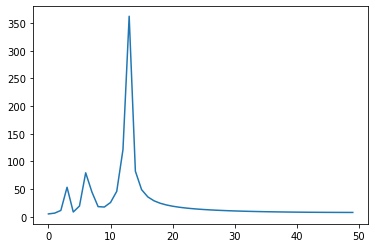

In [31]:
fft = np.fft.fft(signal)[:50]
fft = np.abs(fft)

plt.plot(fft)
plt.show()

Vemos aquí 3 frecuencias: 4, 7 y 14 bits por segundo, exactamente como construimos nuestra señal, Aquí usamos sólo la primera mitad del valor de retorno porque el resultado de la FFT es simetrico

Resulta que cada sonido (incluso el habla humana) está compuesto de muchas de estas ondas coseno básicas en diferentes fecuencias.

Tenemos una forma de obtener frecuencias de cualquier señal de sonido, pero el habla humana no es un ruido estático, cambia con el tiempo, así que para representar correctamente el habla humana, descompondremos nuestras grabaciones en pequeñas ventanas y calcularemos que frecuencia qué frecuencia se utiliza en cada ventana

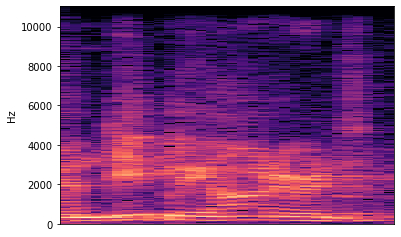

In [32]:
import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.show()


    librosa.stft: calcula la Transformada de Fourier. Los valores de retorno son una matriz donde X son los números de ventana e Y son las frecuencias.
    np.abs: Toma el absoluto del stft en caso de número complejo devuelve el absoluto de la parte real.
    librosa.amplitud_a_db: Convierte los valores a Decibelios
    librosa.display.specshow: Muestra el espectrograma.



El espectrograma nos muestra diferentes frecuencias en diferentes partes de la grabación de la voz. Otra de las propiedades fundamentales es que a nivel de representación son muy similares a una imagen en blanco y negro


In [33]:
# El espectrograma puede interpretarse como una imagen
D.shape

(1025, 32)

# 1. Presentación del conjunto de datos

In [35]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print('[+] Parsing {} data...'.format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
            X.append(D)
            y.append(index)
    return (X, y)

In [36]:
# X_prep, y_prep = parse_dataset([BENJAMIN_DATA, JENS_DATA])
X_prep, y_prep = parse_dataset([JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])

[+] Parsing 16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing 16000_pcm_speeches\Julia_Gillard data...
[+] Parsing 16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing 16000_pcm_speeches\Nelson_Mandela data...


In [37]:
X_prep[100].max()

-3.8146973e-06

# 2. División del conjunto de datos

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [39]:
print(len(X_train))
print(len(X_test))

5700
301


# 3. Construcción del modelo

Preprocesamos los subconjuntos de datos para que puedan ser posteriormente procesados por la red neuronal artificial

In [40]:
X_train_prep = np.array(X_train).reshape((len(X_train), 1025*32))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 1025*32))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [41]:
X_train_prep[0]

array([-0.12291938, -0.14644764, -0.28598443, ..., -0.3137255 ,
       -0.29953533, -0.2628054 ], dtype=float32)

In [42]:
# Entrenamos un Perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train_prep)

C:\Users\luigi\.conda\envs\curso_deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [44]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test_prep)

In [45]:
# Mostramos el f1_score resultante de la predicción
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average="weighted")

0.9366605122229551